한글 폰트 설정

In [14]:
# 1. 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt

# 2. 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 3. 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,391 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and dire

구글드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


라이브러리 임포트 및 경로 설정

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. 데이터 로드 및 전처리
# 파일 경로 설정
base_path='/content/drive/MyDrive/Colab Notebooks/2025-2 데이터애널리틱스'
cohort_ver47_path=os.path.join(base_path,'cohort_ver47_with_cci_hfrs.csv')

기본 설정

In [3]:
import platform
from matplotlib import font_manager, rc
import re

# 운영체제별 폰트 설정
system_name = platform.system()

if system_name == 'Windows':
    # 윈도우
    rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':
    # 맥 (Mac)
    rc('font', family='AppleGothic')
elif system_name == 'Linux':
    # 코랩 / 리눅스 (나눔글꼴 설치 필요)
    rc('font', family='NanumBarunGothic')
else:
    print("Unknown System")

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False
# 데이터 읽기
df = pd.read_csv(cohort_ver47_path)

# 시간 관련 컬럼 datetime 변환
time_cols = [
    'icu_intime', 'icu_outtime', 'admittime', 'dischtime',
    'ed_intime', 'ed_outtime',
    'first_ecg_charttime', 'first_stemi_ecg_time',
    'pci_starttime', 'pci_endtime'
]

for col in time_cols:
    # errors='coerce': 변환 불가능한 값은 NaT(결측) 처리
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [5]:
df.shape[0]

1930

In [6]:
df.count()

,0
subject_id,1930
hadm_id,1930
icu_stay_id,1930
icu_intime,1779
icu_outtime,1779
gender,1930
race,1930
arrival_transport,836
disposition,1930
admittime,371


In [10]:
print(df[['first_ecg_charttime', 'first_stemi_ecg_time', 'ecg_count', 'ecg_stemi_count', 'pci_starttime', 'pci_endtime', 'pci_code']].isnull().sum())

first_ecg_charttime       49
first_stemi_ecg_time    1015
ecg_count                  0
ecg_stemi_count            0
pci_starttime           1240
pci_endtime             1240
pci_code                 934
dtype: int64


# 이상치/노이즈/결측치 확인

In [7]:
# 2. Outlier/Noise/결측치 확인

print("=== 1. 결측치 확인 (Missing Values) ===")
print(df[['pci_code', 'pci_starttime', 'ecg_count', 'first_ecg_charttime']].isnull().sum())

print("\n=== 2. PCI Code 노이즈 확인 (Unique Values) ===")
# ICD 코드와 ITEM_ID가 섞여 있는지 확인
print(df['pci_code'].unique()[:10])

# 파생 변수 생성: PCI Duration (분 단위)
df['pci_duration_min'] = (df['pci_endtime'] - df['pci_starttime']).dt.total_seconds() / 60

# 이상치 확인 (PCI 시간이 음수거나 지나치게 긴 경우)
outlier_pci_minus = df[df['pci_duration_min']<0] #음수
outlier_pci_long = df[df['pci_duration_min']>600] #10시간 이상
print(f"\n=== 3. PCI Duration outlier 개수 ===")
print(f"\n음수 시간 이상치 개수: {len(outlier_pci_minus)}")
print(f"\n10시간 이상 이상치 개수: {len(outlier_pci_long)}")

=== 1. 결측치 확인 (Missing Values) ===
pci_code                934
pci_starttime          1240
ecg_count                 0
first_ecg_charttime      49
dtype: int64

=== 2. PCI Code 노이즈 확인 (Unique Values) ===
['B211YZZ' '027034Z' 'B2111ZZ' '271346' nan 'ITEM_229351' '66' '02100Z9'
 '02703ZZ' '3721']

=== 3. PCI Duration outlier 개수 ===

음수 시간 이상치 개수: 0

10시간 이상 이상치 개수: 620


# 코호트 분포 시각화

/tmp/ipython-input-2333060886.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_pci.values, y=top_pci.index, palette='viridis')
/tmp/ipython-input-2333060886.py:31: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2333060886.py:31: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2333060886.py:31: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2333060886.py:31: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2333060886.py:31: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


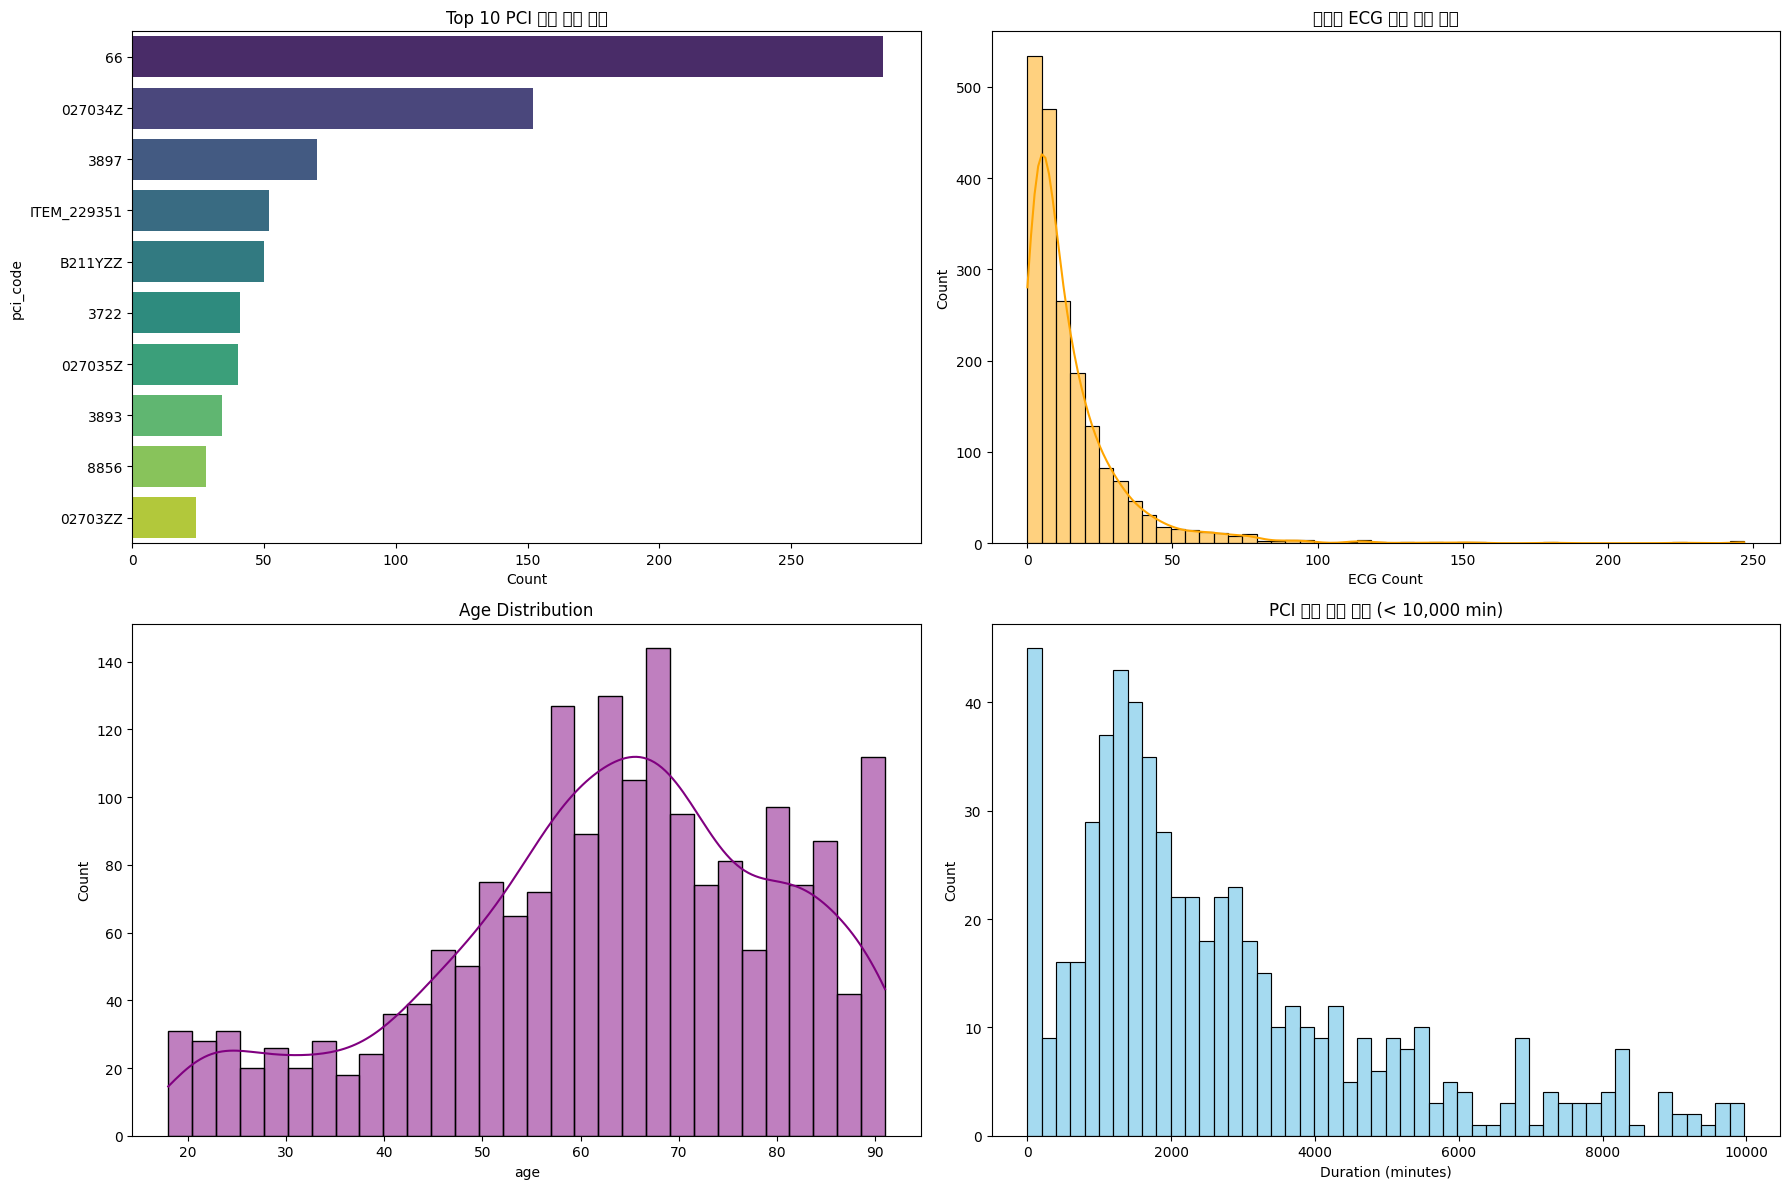


=== 4. ECG Timing Analysis (Door-to-ECG) ===
count     763.000000
mean       47.267366
std       109.315968
min         0.000000
25%         8.000000
50%        13.000000
75%        35.000000
max      1282.000000
Name: door_to_ecg_min, dtype: float64


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


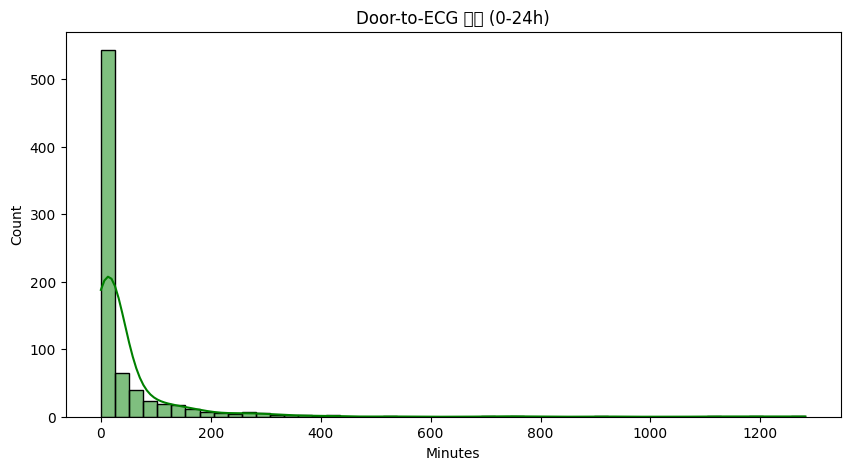

In [8]:





# ==========================================
# 3. Data 분포 확인 및 시각화
# ==========================================
plt.figure(figsize=(18, 12))

# 1) PCI Code 빈도 (Top 10)
plt.subplot(2, 2, 1)
top_pci = df['pci_code'].value_counts().head(10)
sns.barplot(x=top_pci.values, y=top_pci.index, palette='viridis')
plt.title('Top 10 PCI 시술 코드 빈도')
plt.xlabel('Count')

# 2) ECG Count 분포
plt.subplot(2, 2, 2)
sns.histplot(df['ecg_count'], bins=50, kde=True, color='orange')
plt.title('환자별 ECG 촬영 횟수 분포')
plt.xlabel('ECG Count')

# 3) Age 분포
plt.subplot(2, 2, 3)
sns.histplot(df['age'], bins=30, kde=True, color='purple')
plt.title('Age Distribution')

# 4) PCI Duration 분포 (로그 스케일 적용 고려 가능하나 여기선 원본)
plt.subplot(2, 2, 4)
# 시각화를 위해 10000분 이하만 필터링해서 표시
sns.histplot(df[df['pci_duration_min'] < 10000]['pci_duration_min'], bins=50, kde=False, color='skyblue')
plt.title('PCI 시술 시간 분포 (< 10,000 min)')
plt.xlabel('Duration (minutes)')

plt.tight_layout()
plt.show()

# ==========================================
# 4. ECG Time-Series 관련 정보 (Timing Analysis)
# ==========================================
# Time-Series 파형 데이터가 없으므로, '시간 간격(Interval)'을 분석
# Door-to-ECG: 응급실 도착(ed_intime)부터 첫 ECG(first_ecg_charttime)까지의 시간

df['door_to_ecg_min'] = (df['first_ecg_charttime'] - df['ed_intime']).dt.total_seconds() / 60

# 유효한 시간대(0분 ~ 24시간 이내) 필터링
valid_door_to_ecg = df[(df['door_to_ecg_min'] >= 0) & (df['door_to_ecg_min'] <= 1440)]

print("\n=== 4. ECG Timing Analysis (Door-to-ECG) ===")
print(valid_door_to_ecg['door_to_ecg_min'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(valid_door_to_ecg['door_to_ecg_min'], bins=50, kde=True, color='green')
plt.title('Door-to-ECG 분포 (0-24h)')
plt.xlabel('Minutes')
plt.show()

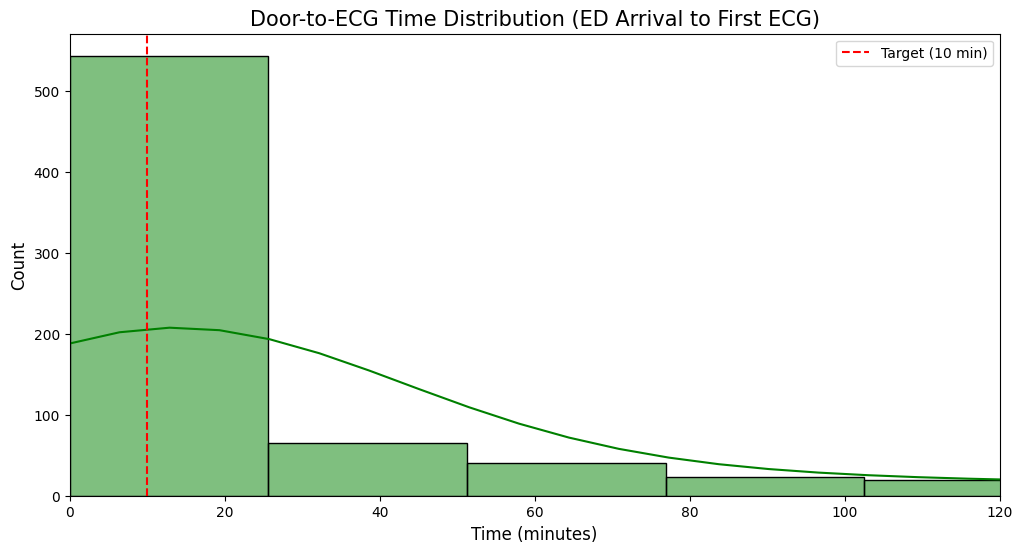

=== Door-to-ECG Time Statistics (minutes) ===
count     763.000000
mean       47.267366
std       109.315968
min         0.000000
25%         8.000000
50%        13.000000
75%        35.000000
max      1282.000000
Name: door_to_ecg_min, dtype: float64


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 준비 (이미 로드된 df가 있다고 가정)
# df = pd.read_csv('cohort_ver47_with_cci_hfrs.csv')

# 시간 컬럼 변환 (혹시 안 되어 있을 경우를 대비해 안전장치)
df['ed_intime'] = pd.to_datetime(df['ed_intime'], errors='coerce')
df['first_ecg_charttime'] = pd.to_datetime(df['first_ecg_charttime'], errors='coerce')

# 2. Door-to-ECG 시간 계산 (분 단위)
# 응급실 도착 시간(ed_intime) vs 첫 ECG 시간(first_ecg_charttime)
df['door_to_ecg_min'] = (df['first_ecg_charttime'] - df['ed_intime']).dt.total_seconds() / 60

# 3. 이상치 필터링 (유효한 데이터만 추출)
# - 음수 값 제거 (기록 오류)
# - 24시간(1440분) 초과 제거 (분석 목적에 맞게 조정 가능, 보통 STEMI는 10분 내 권장되므로 24시간이면 충분히 긴 범위)
valid_door_to_ecg = df[(df['door_to_ecg_min'] >= 0) & (df['door_to_ecg_min'] <= 1440)]

# 4. 시각화 (히스토그램 + KDE)
plt.figure(figsize=(12, 6))

# 메인 히스토그램
sns.histplot(data=valid_door_to_ecg, x='door_to_ecg_min', bins=50, kde=True, color='green')

# 가이드라인 기준선 표시 (10분)
plt.axvline(x=10, color='red', linestyle='--', label='Target (10 min)')

# 그래프 꾸미기
plt.title('Door-to-ECG Time Distribution (ED Arrival to First ECG)', fontsize=15)
plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.xlim(0, 120)  # 대부분의 데이터가 있는 0~120분 구간을 확대해서 보기 (선택사항)

plt.show()

# 5. 요약 통계 출력
print("=== Door-to-ECG Time Statistics (minutes) ===")
print(valid_door_to_ecg['door_to_ecg_min'].describe())

/tmp/ipython-input-909212736.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['pci_start_hour'].dropna().astype(int), palette=palette)


ValueError: The palette dictionary is missing keys: {'4', '5', '3', '0', '10', '7', '1', '18', '2', '11', '14', '9', '23', '15', '19', '20', '13', '16', '22', '21', '12', '8', '6', '17'}

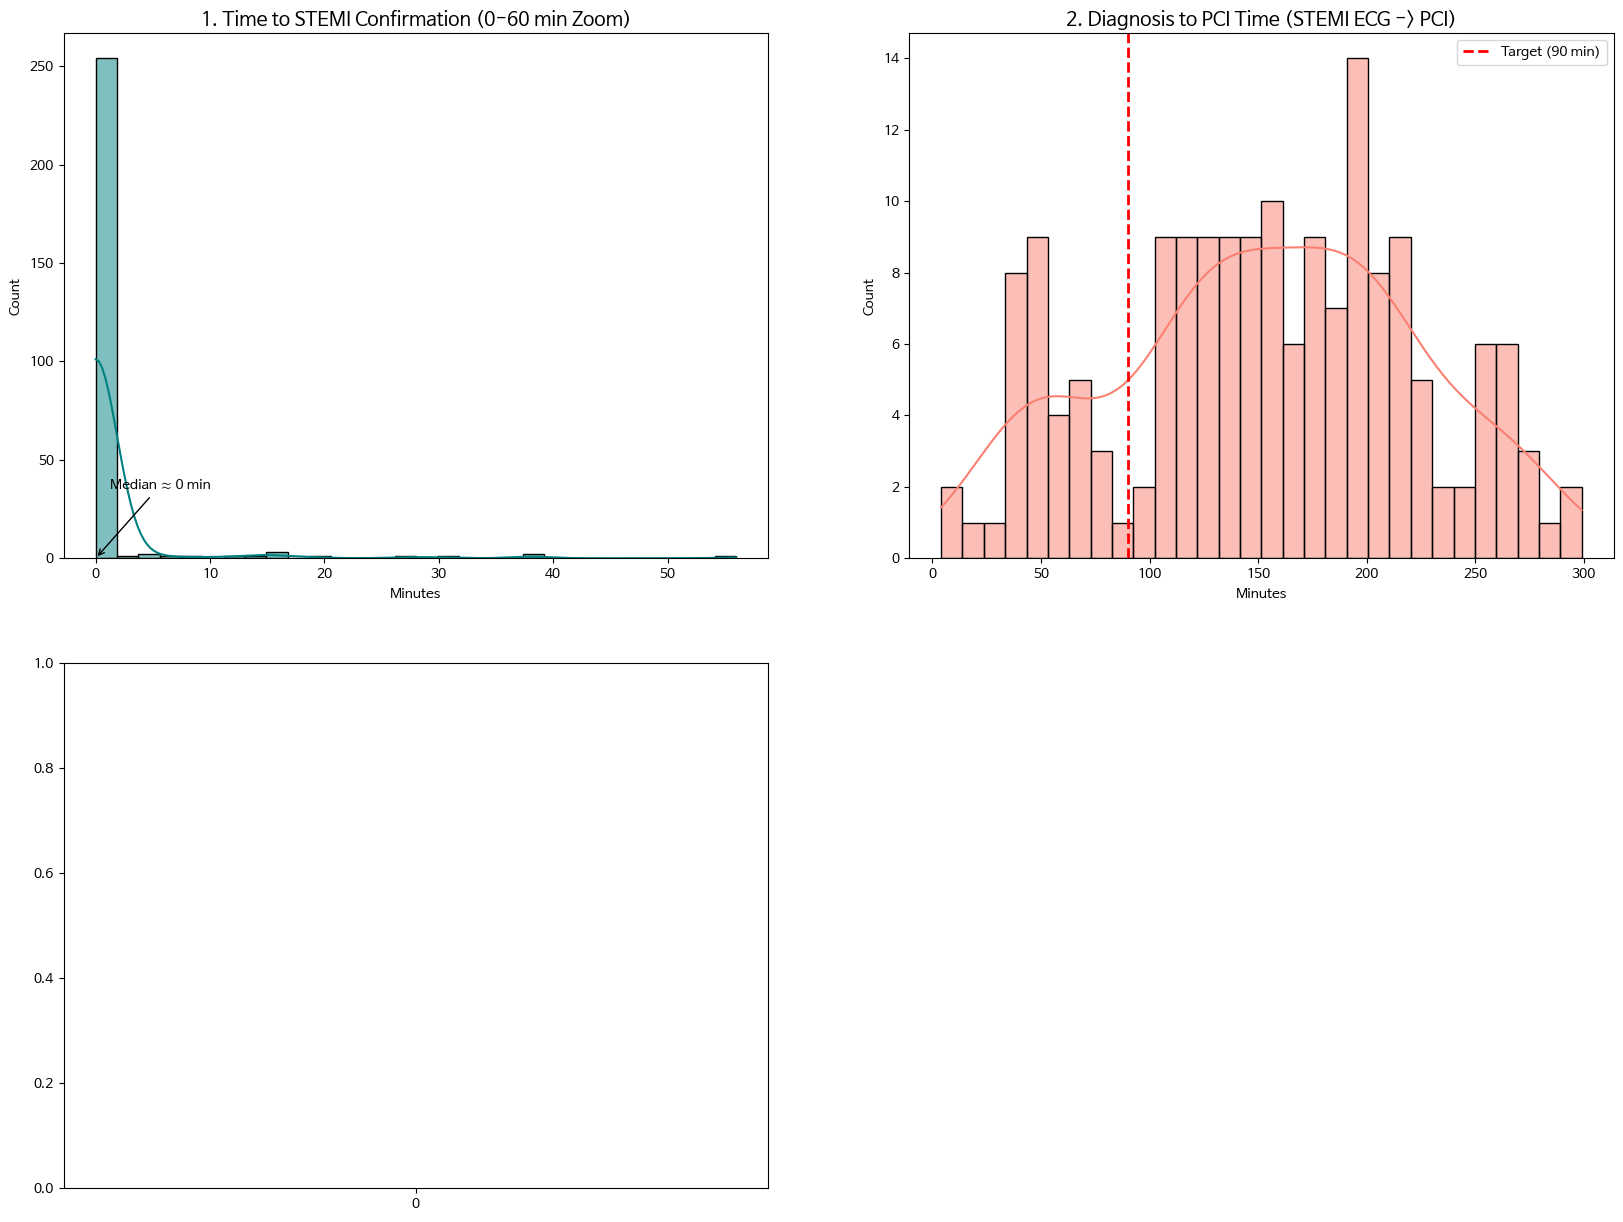

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 데이터 로드 및 전처리
# df = pd.read_csv('cohort_ver47_with_cci_hfrs.csv') # 파일 경로에 맞게 주석 해제

# 시간 컬럼 변환
time_cols = ['first_ecg_charttime', 'first_stemi_ecg_time', 'pci_starttime', 'ed_intime']
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# ==========================================
# 파생 변수 생성 (Feature Engineering)
# ==========================================

# 1. Time to STEMI Confirmation (분 단위)
# 첫 ECG -> STEMI 확진 ECG 까지의 시간
df['time_to_stemi_conf_min'] = (df['first_stemi_ecg_time'] - df['first_ecg_charttime']).dt.total_seconds() / 60

# 2. Diagnosis-to-PCI Time (분 단위)
# STEMI 확진 -> PCI 시술 시작 시간
df['diag_to_pci_min'] = (df['pci_starttime'] - df['first_stemi_ecg_time']).dt.total_seconds() / 60

# 3. 시간대별 패턴 (Off-Hours)
# PCI 시작 시간의 '시(Hour)' 추출
df['pci_start_hour'] = df['pci_starttime'].dt.hour
# Off-Hours 정의: 18시 ~ 08시 (야간/새벽)
df['is_off_hours'] = df['pci_start_hour'].apply(lambda x: 'Off-Hours (18-08)' if (x < 8 or x >= 18) else 'Business Hours (08-18)')

# 4. STEMI ECG Ratio (중증도 지표)
# 전체 ECG 중 STEMI 소견 비율 (0으로 나누기 방지)
df['stemi_ecg_ratio'] = df.apply(lambda row: row['ecg_stemi_count'] / row['ecg_count'] if row['ecg_count'] > 0 else 0, axis=1)


# ==========================================
# 시각화 (Visualization)
# ==========================================
plt.figure(figsize=(20, 15))

# --- 1. Time to STEMI Confirmation (확진 소요 시간) ---
plt.subplot(2, 2, 1)
# 대부분 0분이므로, 60분 이내 데이터만 확대해서 시각화
valid_conf_time = df[(df['time_to_stemi_conf_min'] >= 0) & (df['time_to_stemi_conf_min'] <= 60)]
sns.histplot(valid_conf_time['time_to_stemi_conf_min'], bins=30, kde=True, color='teal')
plt.title('1. Time to STEMI Confirmation (0-60 min Zoom)', fontsize=14)
plt.xlabel('Minutes')
plt.ylabel('Count')
plt.annotate('Median ≈ 0 min', xy=(0, 0), xytext=(10, 50),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', color='black'))

# --- 2. Diagnosis-to-PCI Time (진단 후 시술 대기 시간) ---
plt.subplot(2, 2, 2)
# 5시간(300분) 이내 데이터만 시각화 (이상치 제외)
valid_diag_pci = df[(df['diag_to_pci_min'] >= 0) & (df['diag_to_pci_min'] <= 300)]
sns.histplot(valid_diag_pci['diag_to_pci_min'], bins=30, kde=True, color='salmon')
plt.axvline(x=90, color='red', linestyle='--', linewidth=2, label='Target (90 min)')
plt.title('2. Diagnosis to PCI Time (STEMI ECG -> PCI)', fontsize=14)
plt.xlabel('Minutes')
plt.legend()

# --- 3. 시간대별 패턴 (Temporal Patterns - Off-Hours) ---
plt.subplot(2, 2, 3)
# 시간대별 색상 구분 (야간: 파랑, 주간: 회색)
palette = {hour: 'royalblue' if (hour < 8 or hour >= 18) else 'lightgray' for hour in range(24)}
sns.countplot(x=df['pci_start_hour'].dropna().astype(int), palette=palette)
plt.title('3. Hourly PCI Procedures (Highlighted Off-Hours)', fontsize=14)
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Procedures')
# 범례 추가 (임의로 생성)
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='royalblue', label='Off-Hours'),
                   Patch(facecolor='lightgray', label='Business Hours')]
plt.legend(handles=legend_elements, loc='upper right')

# --- 4. STEMI ECG Ratio (중증도 지표 분포) ---
plt.subplot(2, 2, 4)
sns.histplot(df['stemi_ecg_ratio'], bins=20, kde=True, color='purple')
plt.title('4. Distribution of STEMI ECG Ratio', fontsize=14)
plt.xlabel('Ratio (STEMI Count / Total ECG Count)')
plt.ylabel('Number of Patients')

plt.tight_layout()
plt.show()

# 통계치 출력
print("=== Summary Statistics ===")
print(f"1. Median Time to Confirmation: {df['time_to_stemi_conf_min'].median()} min")
print(f"2. Mean Diagnosis-to-PCI Time: {valid_diag_pci['diag_to_pci_min'].mean():.1f} min")
print(f"3. Off-Hours PCI Ratio: {df[df['is_off_hours'].str.contains('Off')].shape[0] / df['pci_start_hour'].notnull().sum() * 100:.1f}%")

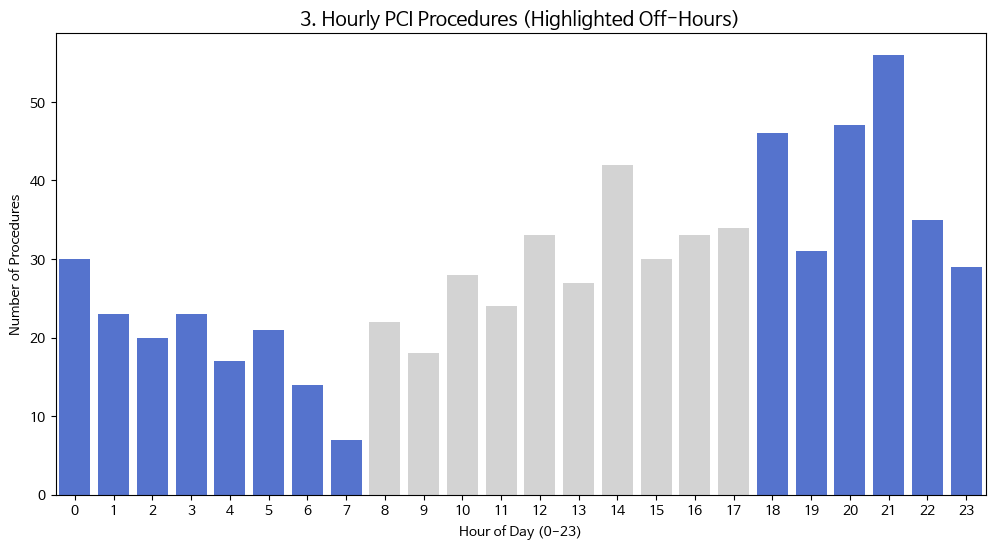

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 준비 (이미 로드된 df가 있다고 가정)
# 시간 컬럼 변환
df['pci_starttime'] = pd.to_datetime(df['pci_starttime'], errors='coerce')

# 시간 추출 및 정수형 변환
df['pci_start_hour'] = df['pci_starttime'].dt.hour
pci_data = df['pci_start_hour'].dropna().astype(int)

# 2. Palette 정의 (키를 정수형으로 수정)
# [수정] str(hour) -> hour (정수형 키 사용)
# 08시~17시: 업무 시간(회색), 그 외: 야간/새벽(파란색)
palette = {hour: 'royalblue' if (hour < 8 or hour >= 18) else 'lightgray' for hour in range(24)}

# 3. 그래프 그리기
plt.figure(figsize=(12, 6))

sns.countplot(
    x=pci_data,
    hue=pci_data,       # Warning 방지용
    palette=palette,
    legend=False        # 범례 숨김
)

plt.title('3. Hourly PCI Procedures (Highlighted Off-Hours)', fontsize=14)
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Procedures')
plt.show()